In [1]:
import pandas as pd
import datetime
import os
import timeit
from ortools.linear_solver import pywraplp

In [2]:
# Read Excel file
file_name = os.fsdecode("CSV/BESS_Data.xlsx")
workbook = pd.ExcelFile(file_name)

output_folder = "output"
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

# Load timeseries data
marketDF = workbook.parse("Timeseries data")
marketDF = marketDF.iloc[:,:5]
marketDF.columns = ["time", "market_price_1", "load", "wind", "solar"]
marketDF = marketDF[~pd.isnull(marketDF["time"])].fillna(0)

market1DF = marketDF.copy()
market1DF.sort_values(by=["time"], inplace=True)
market1DF["time_string"] = market1DF.apply(lambda x:(x["time"]+ datetime.timedelta(seconds=0.002)).strftime("%d/%m/%Y %H:%M"), axis=1)
market1DF.set_index("time_string", inplace=True)
marketDF = market1DF

# Load static data
gridDF = workbook.parse("Grid")
gridDF = gridDF.iloc[:,:4]
gridDF.columns = ["max_buy_power", "max_sell_power", "max_import_power", "max_export_power"]

# Load battery data
battDF = workbook.parse("Battery")
battDF = battDF.iloc[:,:8]
battDF.columns = ["max_charge_rate", "max_discharge_rate", "capacity", "charge_eff", "discharge_eff", "min_soc", "max_soc", "initial_soc"]

# Convert dataframe to dictionary
marketDict = marketDF.to_dict()
gridDict = gridDF.to_dict()
battDict = battDF.to_dict()

timeInterval = marketDF.iloc[1]["time"] - marketDF.iloc[0]["time"]

# Assign the data to right places
input = type("input", (dict,), {})()
input.update({
    "simData": {
        "startTime": datetime.datetime.strptime(marketDF.index[0], "%d/%m/%Y %H:%M"),
        "dt": int(round(timeInterval.total_seconds())) / (60 * 60), #in hour
        "tIndex": marketDF.shape[0]
        },
    "market": {
        key: {
            sub_key: sub_item for sub_key, sub_item in marketDict[key].items()
            } for key in marketDict.keys() if key != "time"
        },
    "grid": {
        key: item[0] for key, item in gridDict.items()
        },
    "batt": {
        key: item[0] for key, item in battDict.items()
        }
    })

In [3]:
# Create the mip solver with the CBC backend.
solver = pywraplp.Solver.CreateSolver("CBC")

inf = solver.infinity()

In [4]:
tIndex = input["simData"]["tIndex"] # number of timeslots
dt = input["simData"]["dt"] # time interval in hour

# Create datetime array
startTime = input["simData"]["startTime"].strftime("%d/%m/%Y %H:%M")
tIndex = input["simData"]["tIndex"]
timestamp = pd.date_range(startTime, periods=tIndex, freq=str(dt * 60) + "min")
time = [timestamp[i].strftime("%d/%m/%Y %H:%M") for i in range(len(timestamp))]

In [5]:
time_s = timeit.default_timer()
# Add timeseries variables
vGrid = [solver.NumVar(lb=-inf, ub=inf, name="") for _ in range(tIndex)]

vBattPower = [solver.NumVar(lb=-inf, ub=inf, name="") for _ in range(tIndex)]
vCharge = [solver.NumVar(lb=-inf, ub=0, name="") for _ in range(tIndex)]
vDischarge = [solver.NumVar(lb=0, ub=inf, name="") for _ in range(tIndex)]
vChargeStatus = [solver.BoolVar(name="") for _ in range(tIndex)]
vSOC = [solver.NumVar(lb=0, ub=1, name="") for _ in range(tIndex)]

In [6]:
# Add constraints
for i in range(tIndex):
    
    t = time[i]
    
    # Grid constraints
    solver.Add(vGrid[i] == input["market"]["load"][t] - input["market"]["solar"][t] - input["market"]["wind"][t] - vBattPower[i]) # Eqn. 1
    solver.Add(vGrid[i] <= input["grid"]["max_buy_power"]) # Eqn. 2
    solver.Add(vGrid[i] >= -input["grid"]["max_sell_power"]) # Eqn. 2
    solver.Add(input["market"]["load"][t] - input["market"]["solar"][t] - input["market"]["wind"][t] + vDischarge[i] + vCharge[i] <= input["grid"]["max_import_power"]) # Eqn. 3
    solver.Add(input["market"]["load"][t] - input["market"]["solar"][t] - input["market"]["wind"][t] + vDischarge[i] + vCharge[i] >= -input["grid"]["max_export_power"]) # Eqn. 3
    
    # Battery constraints
    solver.Add(vBattPower[i] == vCharge[i] + vDischarge[i]) # Eqn. 4
    solver.Add(vCharge[i] >= -input["batt"]["max_charge_rate"] * vChargeStatus[i]) # Eqn. 5(a)
    solver.Add(vDischarge[i] <= input["batt"]["max_discharge_rate"] * (1-vChargeStatus[i])) # Eqn. 5(b)
    
    if i == 0:
        solver.Add(vSOC[i] == input["batt"]["initial_soc"] - dt / input["batt"]["capacity"] * (vCharge[i] * (1-input["batt"]["charge_eff"]) + vDischarge[i] / (1-input["batt"]["discharge_eff"]))) # Eqn. 6
    else:
        solver.Add(vSOC[i] == vSOC[i-1] - dt / input["batt"]["capacity"] * (vCharge[i] * (1-input["batt"]["charge_eff"]) + vDischarge[i] / (1-input["batt"]["discharge_eff"]))) # Eqn. 6
        
    solver.Add(vSOC[i] >= input["batt"]["min_soc"]) # Eqn. 7
    solver.Add(vSOC[i] <= input["batt"]["max_soc"]) # Eqn. 7

In [7]:
# Add objective
obj = 0
obj += sum([vGrid[i] * input["market"]["market_price_1"][time[i]] * dt for i in range(tIndex)])
solver.Minimize(obj)

In [8]:
status = solver.Solve()

time_e = timeit.default_timer()
runTime = round(time_e - time_s, 4)

In [9]:
if status == solver.OPTIMAL or status == solver.FEASIBLE:
    print("Solution is found.")
    print("Number of variables =", solver.NumVariables())
    print("Number of constraints =", solver.NumConstraints())
    print("Computation time = ", runTime)
    
    # Extract solution values
    excelWriter = pd.ExcelWriter('output/Result.xlsx', engine='xlsxwriter')
    
    objValue = round(solver.Objective().Value() / 100, 2)
    
    objValueDF = pd.DataFrame.from_dict({"obj_value": objValue}, orient="index", columns=["Total Cost of Importing Power ($)"])
    
    result = list(zip([round(vGrid[i].solution_value(), 4) for i in range(tIndex)], 
                      [round(vBattPower[i].solution_value(), 4) for i in range(tIndex)],
                      [round(vCharge[i].solution_value(), 4) for i in range(tIndex)],
                      [round(vDischarge[i].solution_value(), 4) for i in range(tIndex)],
                      [round(vSOC[i].solution_value(), 4) for i in range(tIndex)],
                      [int(vChargeStatus[i].solution_value()) for i in range(tIndex)]
                      ))
    resultDF = pd.DataFrame(result, index=time, columns=["Grid Power Flow (kW)", "Battery Output (kW)", "Charging Power (kW)", "Discharging Power (kW)", "State-of-charge (SOC)", "Charge Status"])
    
    objValueDF.to_excel(excelWriter, sheet_name='Cost')
    resultDF.to_excel(excelWriter, sheet_name='Operation')
    excelWriter.close()
else:
    print("Solution cannot be found.")

Solution is found.
Number of variables = 288
Number of constraints = 528
Computation time =  5.7395


In [10]:
import pandas as pd

# Load the Excel file
file_path = "Output/Result.xlsx"
xls = pd.ExcelFile(file_path)

# Load the 'Cost' sheet
Operation_df = xls.parse('Operation')

# Rename columns for clarity
Operation_df.columns = ["DateTime", "Grid Power Flow", "Battery Output", "Charging Power", "Discharging Power", "State-of-charge","Charge Status"]

# Display the datagram
print(Operation_df.head())



           DateTime  Grid Power Flow  Battery Output  Charging Power  \
0  01/01/2018 00:00        2037.4848             0.0             0.0   
1  01/01/2018 00:30        2482.9915             0.0             0.0   
2  01/01/2018 01:00         500.9981          2000.0             0.0   
3  01/01/2018 01:30        1038.9961          1040.0             0.0   
4  01/01/2018 02:00        1681.9981             0.0             0.0   

   Discharging Power  State-of-charge  Charge Status  
0                  0           0.5000              0  
1                  0           0.5000              0  
2               2000           0.2368              0  
3               1040           0.1000              0  
4                  0           0.1000              0  


In [11]:
# Step 1: Convert to datetime objects
Operation_df['DateTime_Field'] = pd.to_datetime(Operation_df['DateTime'], format='%d/%m/%Y %H:%M')

# Step 2: Extract and format the time
Operation_df['Time'] = Operation_df['DateTime_Field'].dt.strftime('%H:%M')
print(Operation_df.head())

           DateTime  Grid Power Flow  Battery Output  Charging Power  \
0  01/01/2018 00:00        2037.4848             0.0             0.0   
1  01/01/2018 00:30        2482.9915             0.0             0.0   
2  01/01/2018 01:00         500.9981          2000.0             0.0   
3  01/01/2018 01:30        1038.9961          1040.0             0.0   
4  01/01/2018 02:00        1681.9981             0.0             0.0   

   Discharging Power  State-of-charge  Charge Status      DateTime_Field  \
0                  0           0.5000              0 2018-01-01 00:00:00   
1                  0           0.5000              0 2018-01-01 00:30:00   
2               2000           0.2368              0 2018-01-01 01:00:00   
3               1040           0.1000              0 2018-01-01 01:30:00   
4                  0           0.1000              0 2018-01-01 02:00:00   

    Time  
0  00:00  
1  00:30  
2  01:00  
3  01:30  
4  02:00  


Text(0, 0.5, 'Market price')

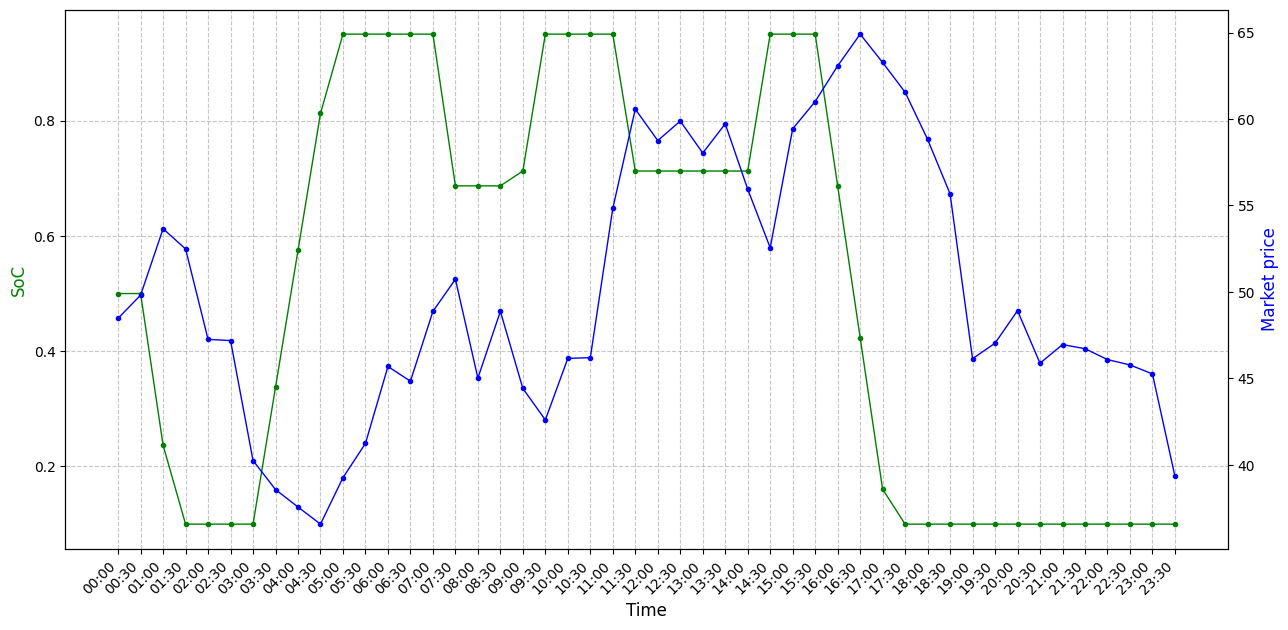

In [31]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 7))

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10) 

ax2 = ax1.twinx()
ax1.plot(Operation_df["Time"], Operation_df["State-of-charge"], marker='o', linestyle='-', color='g', markersize=3, linewidth=1)
ax2.plot(Operation_df["Time"], marketDF["market_price_1"], marker='o', linestyle='-', color='b', markersize=3, linewidth=1)

ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SoC', fontsize=12, color='g')
ax2.set_ylabel('Market price', fontsize=12, color='b')

